In [44]:
import os
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

from matplotlib import pyplot as plt
import seaborn as sns

from utils.settings import periods, frequency_bands, ROI

freqs = []
for mode in list(frequency_bands.keys()):
    freqs.extend(list(frequency_bands[mode].keys()))
    
channels_in_order = []
for channels in list(ROI.values()):
    channels_in_order.extend(channels)

## Compute correlations between connectivity and behavior
### Sample notebook 

#### Load behavior data

In [2]:
# Specify path to behavior data 
behav_path = 'ASRT_connect_consol_behav_selected_zs.csv'

In [3]:
def load_behaviour_data_from_path(path):
    """
    Loads behavior data from given path. Renames columns to make it more readable.
    Returns a dataframe with the selected columns.
    """
    print(f'\nLoading behaviour data from: {path}')
    df = pd.read_csv(path, sep=';', decimal=",")

    columns_readable = {'hldif_Session_I': 's1_hldif_rt',
                        'hldif_Session_I_acc': 's1_hldif_acc',
                        'hldif4': 's2_hldif_rt',
                        'hldif4_acc': 's2_hldif_acc'}

    df.rename(columns=columns_readable, inplace=True)

    selected_columns = ['Subject'] + ['s1_hldif_rt', 's1_hldif_acc',
                                      's2_hldif_rt', 's2_hldif_acc',
                                      'konsz_rt', 'konsz_acc',
                                      'gs_konsz_rt', 'gs_konsz_acc']

    print(df[selected_columns].head(10))

    return df[selected_columns]

In [4]:
behav_data = load_behaviour_data_from_path(path=behav_path)


Loading behaviour data from: /Users/weian/research/crnl/eeg-connectivity-analysis/ASRT_connect_consol_behav_selected_zs.csv
   Subject  s1_hldif_rt  s1_hldif_acc  s2_hldif_rt  s2_hldif_acc  konsz_rt  \
0        1     7.500000      0.039356         16.0      0.037931       9.5   
1        2    14.833333      0.046963         15.0      0.104822       6.0   
2        3     3.000000     -0.018952         -3.5     -0.028202      -9.5   
3        4    10.166667      0.008487          9.0      0.010783      -4.0   
4        5     4.333333      0.055089         11.0      0.044036      -2.0   
5        6    20.166667      0.041596         13.5      0.057851     -10.5   
6        7     8.500000      0.024006         16.5      0.053761       6.5   
7        8     3.500000      0.006222          1.0      0.045025      -1.0   
8        9     9.333333      0.071757          8.5      0.051890      -6.0   
9       11    -1.166667      0.054954         10.0      0.052332      14.5   

   konsz_acc  gs

#### Load the connectivity file(s)

In [47]:
# Specify path to resting data
rs_path = '.../result/rs/wpli'

ch_conn_fname, roi_conn_fname = [file for file in sorted(os.listdir(rs_path)) if file.endswith('.npy')]
print(ch_conn_fname)
print(roi_conn_fname)

subjects_wpli_ch_conn.npy
subjects_wpli_roi_conn.npy


In [33]:
def load_connectivity_matrix_from_path(path: str) -> np.ndarray:
    """
    Loads a channel connectivity matrix (.npy) into multidimensional array.
    Checks the shape of the matrix to match the expected number of dimensions:
    (n_subjects, n_periods, n_frequencies, n_channels, n_channels)

    Args:
    str path: the path to the channel connectivity matrix
    :return: the loaded channel matrix with a shape of
    (n_subjects, n_periods, n_frequencies, n_channels, n_channels)
    """
    
    print(f'Reading matrix from {path}\n')
    conn = np.load(path)
    assert len(conn.shape) == 5
    print(f'Shape of matrix: {conn.shape}\n'
                 f'Description of dimensions: \n'
                 f'Number of subjects: {conn.shape[0]}\n'
                 f'Number of periods: {conn.shape[1]}\n'
                 f'Number of frequency bands: {conn.shape[2]}\n'
                 f'Channel connectivity matrix: '
                 f'{conn.shape[3]} x {conn.shape[4]}\n')

    return conn

In [48]:
# Load channel connectivity matrix
rs_wpli_ch_conn = load_connectivity_matrix_from_path(path=os.path.join(rs_path, ch_conn_fname))

# Load ROI matrix
rs_wpli_roi_conn = load_connectivity_matrix_from_path(path=os.path.join(rs_path, roi_conn_fname))

Reading matrix from /Users/weian/research/crnl/eeg-connectivity-analysis/result/rs/wpli/subjects_wpli_ch_conn.npy

Shape of matrix: (30, 4, 5, 47, 47)
Description of dimensions: 
Number of subjects: 30
Number of periods: 4
Number of frequency bands: 5
Channel connectivity matrix: 47 x 47

Reading matrix from /Users/weian/research/crnl/eeg-connectivity-analysis/result/rs/wpli/subjects_wpli_roi_conn.npy

Shape of matrix: (30, 4, 5, 11, 11)
Description of dimensions: 
Number of subjects: 30
Number of periods: 4
Number of frequency bands: 5
Channel connectivity matrix: 11 x 11



#### Calculate correlations
##### Uncorrected Spearman R-values

In [36]:
def uncorrected_spearmanr(conn, behav_vector):
    """
    Calculates Spearman correlations between connectivity matrix (n_subjects, n_channels, n_channels) 
    and behavior data (n_subjects,). 
    The correlations are calculated by iterating over the NxN connectivity matrix
    and selecting the connectivity values at each cell for every subject. For each iteration the Spearman 
    correlation is computed between the connectivity measures (n_subjects,) and the behavior data (n_subjects,).
    Returns a dataFrame with the observed R values for each cell in an NxN correlation matrix.
    """

    if conn.shape[-1] > len(list(ROI.keys())):
        labels = channels_in_order
    else:
        labels = list(ROI.keys())
        
    assert conn.shape[0] == len(behav_vector)
    observed_corr = np.zeros((conn.shape[-1], conn.shape[-1]))

    # calculate observed r-values
    for row in range(conn.shape[-1]):
        for column in range(conn.shape[-1]):
            # ignore upper triangle with zero values
            if all(v == 0 for v in conn[:, row, column]):
                observed_corr[row][column] = 0.0
            else:
                observed_r, observed_p = spearmanr(conn[:, row, column],
                                                   behav_vector)

                observed_corr[row][column] = observed_r

    df = pd.DataFrame(data=observed_corr, index=labels, columns=labels)
    return df

In [97]:
def plot_corr_heatmap(df, scale, title):
    mask = np.zeros_like(df.values)
    mask[df.values == 0] = True

    fig, ax = plt.subplots(figsize=(12, 6))
    plt.title(title, size=12)
    sns.set(style='white', font_scale=1.)
    sns.heatmap(df,
                mask=mask,
                square=True,
                vmin=-scale,
                vmax=scale,
                cbar=False,
                annot=False,
                linewidths=.08,
                linecolor='white',
                cmap="RdBu_r",
                cbar_kws={"shrink": .5},
                ax=ax)
    cax = plt.gcf().axes[0]
    cax.tick_params(labelsize=12)
    fig.tight_layout()
    # uncomment to save figure
#     plt.savefig(
#       os.path.join('presentations/', f'{title.replace(" ", "_")}.png'),
#       dpi=200,
#       transparent=False)
    plt.show()
    plt.close(fig)

In [99]:
freq_name = 'delta'
rs_1_index = periods['rs'].index('ny_1')
freq_index = freqs.index(freq_name)
rs_1_delta = rs_wpli_ch_conn[:, rs_1_index, freq_index, ...]

print(f'Shape of conn matrix: {rs_1_delta.shape}, shape of behav data: {behav_data["s1_hldif_rt"].shape}')
rs_1_delta_corr = uncorrected_spearmanr(conn=rs_1_delta, behav_vector=behav_data['s1_hldif_rt'])
rs_1_delta_corr.head()

Shape of conn matrix: (30, 47, 47), shape of behav data: (30,)


,F7,F5,F3,FC5,FC3,F1,Fz,F2,FC1,FCz,...,CP6,P4,P6,P8,PO3,PO7,O1,PO4,PO8,O2
F7,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F5,0.048281,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F3,0.059183,0.017800,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FC5,0.024029,-0.066971,0.011347,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FC3,-0.008010,0.132162,0.104350,0.026699,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


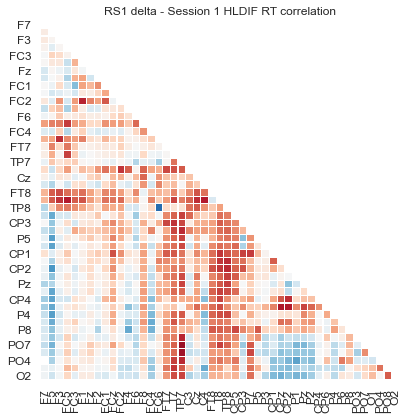

In [96]:
plot_corr_heatmap(df=rs_1_delta_corr, scale=0.6, title='RS1 delta - Session 1 HLDIF RT correlation')

Shape of conn matrix: (30, 11, 11), shape of behav data: (30,)


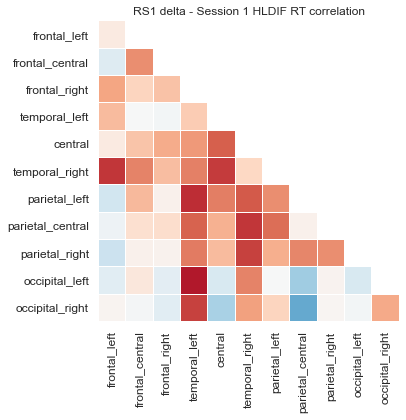

In [98]:
rs_1_delta_roi = rs_wpli_roi_conn[:, rs_1_index, freq_index, ...]

print(f'Shape of conn matrix: {rs_1_delta_roi.shape}, shape of behav data: {behav_data["s1_hldif_rt"].shape}')
rs_1_delta_roi_corr = uncorrected_spearmanr(conn=rs_1_delta_roi, behav_vector=behav_data['s1_hldif_rt'])
plot_corr_heatmap(df=rs_1_delta_roi_corr, scale=0.6, title='RS1 delta - Session 1 HLDIF RT correlation')